<a href="https://www.kaggle.com/code/trnkimdng/stage-2?scriptVersionId=261058775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data processing

In [138]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import pydicom
import numpy as np
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt

In [139]:
df_train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
label_train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_desc = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
coords_improved = pd.read_csv('/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv')
coords_improved.drop('Unnamed: 0', axis=1, inplace=True)

In [140]:
sagittal_t1 = train_desc[train_desc['series_description'] == 'Sagittal T1']
sagittal_t2 = train_desc[train_desc['series_description'] == 'Sagittal T2/STIR']
axial_t2 = train_desc[train_desc['series_description'] == 'Axial T2']

sagittal_t1 = sagittal_t1.merge(coords_improved)
sagittal_t2 = sagittal_t2.merge(coords_improved)
axial_t2 = axial_t2.merge(coords_improved)

In [141]:
df_train.fillna('N', inplace=True)

In [142]:
temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number'])//len(x)).reset_index(name='instance_number')

/tmp/ipykernel_34/521533411.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
/tmp/ipykernel_34/521533411.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_numb

In [143]:
temp2.head()

,study_id,series_id,side,instance_number
0,4003253,1054713880,L,11
1,4003253,1054713880,R,5
2,4646740,3486248476,L,5
3,4646740,3486248476,R,16
4,7143189,3219733239,L,12


In [144]:
temp3 = temp1.merge(temp2)

In [145]:
temp3

,study_id,series_id,side,coords,instance_number
0,4003253,1054713880,L,"[(0.510600707, 0.328180212), (0.498233216, 0.4...",11
1,4003253,1054713880,R,"[(0.506692161, 0.332695985), (0.499043977, 0.4...",5
2,4646740,3486248476,L,"[(0.626783014, 0.257839761), (0.609633623, 0.3...",5
3,4646740,3486248476,R,"[(0.622343335, 0.270243791), (0.578518862, 0.3...",16
4,7143189,3219733239,L,"[(0.547664196, 0.272829157), (0.536405631, 0.3...",12
...,...,...,...,...,...
3953,4284048608,1875151370,R,"[(0.492162339, 0.328502415), (0.466397444, 0.4...",6
3954,4287160193,327893304,L,"[(0.513798254, 0.307352941), (0.485857077, 0.4...",4
3955,4287160193,327893304,R,"[(0.518999752, 0.2998679), (0.483332645, 0.405...",11
3956,4290709089,4237840455,L,"[(0.571525886, 0.254768392), (0.534741145, 0.3...",11


In [146]:
scs_severity = df_train.iloc[:, :6]

In [147]:
scs_severity.columns = ['study_id', 'scs_l1_l2', 'scs_l2_l3', 'scs_l3_l4', 'scs_l4_l5', 'scs_l5_s1']

In [148]:
scs_severity

,study_id,scs_l1_l2,scs_l2_l3,scs_l3_l4,scs_l4_l5,scs_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild


In [149]:
temp3.merge(scs_severity)

,study_id,series_id,side,coords,instance_number,scs_l1_l2,scs_l2_l3,scs_l3_l4,scs_l4_l5,scs_l5_s1
0,4003253,1054713880,L,"[(0.510600707, 0.328180212), (0.498233216, 0.4...",11,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4003253,1054713880,R,"[(0.506692161, 0.332695985), (0.499043977, 0.4...",5,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
2,4646740,3486248476,L,"[(0.626783014, 0.257839761), (0.609633623, 0.3...",5,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild
3,4646740,3486248476,R,"[(0.622343335, 0.270243791), (0.578518862, 0.3...",16,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild
4,7143189,3219733239,L,"[(0.547664196, 0.272829157), (0.536405631, 0.3...",12,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...
3953,4284048608,1875151370,R,"[(0.492162339, 0.328502415), (0.466397444, 0.4...",6,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
3954,4287160193,327893304,L,"[(0.513798254, 0.307352941), (0.485857077, 0.4...",4,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
3955,4287160193,327893304,R,"[(0.518999752, 0.2998679), (0.483332645, 0.405...",11,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
3956,4290709089,4237840455,L,"[(0.571525886, 0.254768392), (0.534741145, 0.3...",11,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [150]:
temp3['scs'] = temp3.merge(scs_severity).apply(lambda x: list(zip(x['scs_l1_l2'][0], x['scs_l2_l3'][0], x['scs_l3_l4'][0], x['scs_l4_l5'][0], x['scs_l5_s1'][0])), axis=1)

In [151]:
temp3

,study_id,series_id,side,coords,instance_number,scs
0,4003253,1054713880,L,"[(0.510600707, 0.328180212), (0.498233216, 0.4...",11,"[(N, N, N, N, N)]"
1,4003253,1054713880,R,"[(0.506692161, 0.332695985), (0.499043977, 0.4...",5,"[(N, N, N, N, N)]"
2,4646740,3486248476,L,"[(0.626783014, 0.257839761), (0.609633623, 0.3...",5,"[(N, N, M, S, N)]"
3,4646740,3486248476,R,"[(0.622343335, 0.270243791), (0.578518862, 0.3...",16,"[(N, N, M, S, N)]"
4,7143189,3219733239,L,"[(0.547664196, 0.272829157), (0.536405631, 0.3...",12,"[(N, N, N, N, N)]"
...,...,...,...,...,...,...
3953,4284048608,1875151370,R,"[(0.492162339, 0.328502415), (0.466397444, 0.4...",6,"[(N, N, N, S, N)]"
3954,4287160193,327893304,L,"[(0.513798254, 0.307352941), (0.485857077, 0.4...",4,"[(N, M, N, N, N)]"
3955,4287160193,327893304,R,"[(0.518999752, 0.2998679), (0.483332645, 0.405...",11,"[(N, M, N, N, N)]"
3956,4290709089,4237840455,L,"[(0.571525886, 0.254768392), (0.534741145, 0.3...",11,"[(N, N, N, N, N)]"


In [152]:
temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number'])//len(x)).reset_index(name='instance_number')

scs = df_train.iloc[:, :6]
l_nfn = df_train.iloc[:, [0, 6, 7, 8, 9, 10]]
r_nfn = df_train.iloc[:, [0, 11, 12, 13, 14, 15]]
l_ss = df_train.iloc[:, [0, 16, 17, 18, 19, 20]]
r_ss = df_train.iloc[:, [0, 21, 22, 23, 24, 25]]

scs.columns = ['study_id', '0', '1', '2', '3', '4']
l_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
r_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
l_ss.columns = ['study_id', '0', '1', '2', '3', '4']
r_ss.columns = ['study_id', '0', '1', '2', '3', '4']

temp3 = temp1.merge(temp2)
temp3['file_path'] = temp3.apply(lambda x: os.path.join(str(x['study_id']), str(x['series_id']), str(x['instance_number']) + '.dcm'), axis=1)

temp3['scs'] = temp3.merge(scs).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_nfn'] = temp3.merge(l_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_nfn'] = temp3.merge(r_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_ss'] = temp3.merge(l_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_ss'] = temp3.merge(r_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)

sagittal_t1_crop = temp3

/tmp/ipykernel_34/34923942.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
/tmp/ipykernel_34/34923942.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp2 = sagittal_t1.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number

In [153]:
sagittal_t1_crop.head()
# sagittal_t1_crop_l = sagittal_t1_crop[sagittal_t1_crop['side'] == 'L']
# sagittal_t1_crop_r = sagittal_t1_crop[sagittal_t1_crop['side'] == 'R']

,study_id,series_id,side,coords,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss
0,4003253,1054713880,L,"[(0.510600707, 0.328180212), (0.498233216, 0.4...",11,4003253/1054713880/11.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
1,4003253,1054713880,R,"[(0.506692161, 0.332695985), (0.499043977, 0.4...",5,4003253/1054713880/5.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
2,4646740,3486248476,L,"[(0.626783014, 0.257839761), (0.609633623, 0.3...",5,4646740/3486248476/5.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
3,4646740,3486248476,R,"[(0.622343335, 0.270243791), (0.578518862, 0.3...",16,4646740/3486248476/16.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
4,7143189,3219733239,L,"[(0.547664196, 0.272829157), (0.536405631, 0.3...",12,7143189/3219733239/12.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"


In [154]:
temp1 = sagittal_t2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
temp2 = sagittal_t2[sagittal_t2['side'] == 'R']
temp2 = temp2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number'])//len(x)).reset_index(name='instance_number')

scs = df_train.iloc[:, :6]
l_nfn = df_train.iloc[:, [0, 6, 7, 8, 9, 10]]
r_nfn = df_train.iloc[:, [0, 11, 12, 13, 14, 15]]
l_ss = df_train.iloc[:, [0, 16, 17, 18, 19, 20]]
r_ss = df_train.iloc[:, [0, 21, 22, 23, 24, 25]]

scs.columns = ['study_id', '0', '1', '2', '3', '4']
l_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
r_nfn.columns = ['study_id', '0', '1', '2', '3', '4']
l_ss.columns = ['study_id', '0', '1', '2', '3', '4']
r_ss.columns = ['study_id', '0', '1', '2', '3', '4']

temp3 = temp1.merge(temp2)
temp3['file_path'] = temp3.apply(lambda x: os.path.join(str(x['study_id']), str(x['series_id']), str(x['instance_number']) + '.dcm'), axis=1)

temp3['scs'] = temp3.merge(scs).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_nfn'] = temp3.merge(l_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_nfn'] = temp3.merge(r_nfn).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['l_ss'] = temp3.merge(l_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)
temp3['r_ss'] = temp3.merge(r_ss).apply(lambda x: list(zip(x['0'][0], x['1'][0], x['2'][0], x['3'][0], x['4'][0])), axis=1)

sagittal_t2_crop = temp3

/tmp/ipykernel_34/1566877174.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = sagittal_t2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')
/tmp/ipykernel_34/1566877174.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp2 = temp2.groupby(['study_id', 'series_id', 'side']).apply(lambda x: sum(x['instance_number']

In [155]:
sagittal_t2_crop.head()

,study_id,series_id,side,coords,instance_number,file_path,scs,l_nfn,r_nfn,l_ss,r_ss
0,4003253,702807833,R,"[(0.504424779, 0.35619469), (0.500892857, 0.46...",8,4003253/702807833/8.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, N)]","[(N, N, M, M, N)]","[(N, N, N, M, N)]","[(N, N, N, N, N)]"
1,4646740,3666319702,R,"[(0.629427191, 0.289215686), (0.616893768, 0.4...",10,4646740/3666319702/10.dcm,"[(N, N, M, S, N)]","[(N, N, N, M, M)]","[(N, N, M, M, N)]","[(N, N, N, S, N)]","[(N, M, M, M, N)]"
2,7143189,132939515,R,"[(0.556057713, 0.292898133), (0.537979692, 0.4...",9,7143189/132939515/9.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"
3,8785691,481125819,R,"[(0.568548387, 0.301523298), (0.538082437, 0.4...",8,8785691/481125819/8.dcm,"[(N, N, N, N, N)]","[(N, N, N, M, M)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]"
4,10728036,3491739931,R,"[(0.580899374, 0.290849673), (0.578720724, 0.4...",11,10728036/3491739931/11.dcm,"[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, N, N)]","[(N, N, N, M, N)]"


In [156]:
temp1 = axial_t2.groupby(['study_id', 'series_id', 'level']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')

/tmp/ipykernel_34/3611829842.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1 = axial_t2.groupby(['study_id', 'series_id', 'level']).apply(lambda x: list(zip(x['relative_x'], x['relative_y']))).reset_index(name='coords')


In [157]:
temp1.head()

,study_id,series_id,level,coords
0,4003253,2448190387,L1/L2,"[(0.55977015, 0.503861004), (0.454027411, 0.49..."
1,4003253,2448190387,L2/L3,"[(0.565561655, 0.496138996), (0.455937631, 0.4..."
2,4003253,2448190387,L3/L4,"[(0.55011764, 0.492277992), (0.446386532, 0.48..."
3,4003253,2448190387,L4/L5,"[(0.54046513, 0.49034749), (0.46071318, 0.4937..."
4,4003253,2448190387,L5/S1,"[(0.561700652, 0.505791506), (0.455937631, 0.5..."


In [158]:
TRAIN_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"
BASE_DIR = "/kaggle/input/axial-cropped/kaggle/working/axial_cropped_dataset"

# Dataset

In [159]:
import pydicom
import numpy as np
from PIL import Image

In [160]:
df_axis_cropped = pd.read_csv("/kaggle/input/axial-with-box-df/axial_with_box_df.csv")
len(df_axis_cropped)

3290

In [161]:
df_axis_cropped.groupby("study_id").size().unique()

array([ 5,  6,  7,  4, 10,  3,  8, 13, 12,  9, 11,  2])

In [162]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from scipy.interpolate import splprep, splev
import pydicom


def load_dcm_image(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    img -= img.min()
    img /= (img.max() + 1e-5)
    return img

def crop_centered_patches(image, keypoints, box_width=150, box_height=100):
    """
    Crop các patch hình chữ nhật không xoay, centered tại các keypoint.
    """
    h, w = image.shape
    patches = []

    for px, py in keypoints:
        cx = int(px)
        cy = int(py)

        x1 = max(cx - box_width // 2, 0)
        y1 = max(cy - box_height // 2, 0)
        x2 = min(cx + box_width // 2, w)
        y2 = min(cy + box_height // 2, h)

        patch = image[y1:y2, x1:x2]

        # Resize lại nếu patch nhỏ hơn box (do bị cắt ở biên)
        patch = cv2.resize(patch, (box_width, box_height))
        patches.append(patch)

    return patches

def crop_patch_by_spline(image, all_coords, disc_idx, box_width=150, box_height=100):
    h, w = image.shape
    keypoints = [(x * w, y * h) for x, y in all_coords]

    patches = crop_centered_patches(image, keypoints, box_width, box_height)
    return patches[disc_idx]

def load_png_image(path, box_width=150, box_height=100):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img -= img.min()
    img /= (img.max() + 1e-5)

    # Resize cho cùng kích thước với crop từ DICOM
    img = cv2.resize(img, (box_width, box_height))
    return img

class SpineMultiViewDiscDataset(Dataset):
    def __init__(self, df1, df2, df3, resize=(150, 100), base_dir=TRAIN_DIR, base_dir_axial=BASE_DIR, transform=None, iloc=0, condition='scs'):
        self.samples = []
        self.resize = resize
        self.base_dir = base_dir
        self.base_dir_axial = base_dir_axial
        self.transform = transform
        self.iloc = iloc
        self.condition = condition
        label_map = {'N': 0, 'M': 1, 'S': 2}

        # Lấy danh sách các study_id duy nhất
        study_ids = df1['study_id'].unique()

        for sid in study_ids:
            rows1 = df1[df1['study_id'] == sid]
            rows2 = df2[df2['study_id'] == sid]
            rows3 = df3[df3['study_id'] == sid]
            if len(rows1) == 0 or len(rows2) == 0 or len(rows3) != 5:
                continue

            # Chọn một dòng duy nhất từ mỗi dataframe
            row1 = rows1.iloc[self.iloc]
            row2 = rows2.iloc[0]

            coords1 = row1['coords']
            coords2 = row2['coords']
            labels = row1[condition]

            for i in range(5):  # 5 disc levels
                row3 = rows3[rows3["pred_level"] == i + 1].iloc[0]
                label_char = labels[0][i] if isinstance(labels, list) else labels[i]
                label = label_map.get(label_char)
                sample = {
                    'file1': f"{self.base_dir}/{row1['file_path']}",
                    'file2': f"{self.base_dir}/{row2['file_path']}",
                    'file3': f"{self.base_dir_axial}/{row3['study_id']}___{row3['series_id']}___{row3['instance_number']}.png",
                    'all_coords1': coords1,
                    'all_coords2': coords2,
                    'label': label,
                    'disc_level': i
                }
                self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        img1 = load_dcm_image(sample['file1'])
        img2 = load_dcm_image(sample['file2'])
        img3 = load_png_image(sample['file3'])

        crop1 = crop_patch_by_spline(
            img1, sample['all_coords1'], sample['disc_level'],
            box_width=self.resize[0], box_height=self.resize[1]
        )
        crop2 = crop_patch_by_spline(
            img2, sample['all_coords2'], sample['disc_level'],
            box_width=self.resize[0], box_height=self.resize[1]
        )
        
        stacked = np.stack([crop1, crop2, img3], axis=-1)  # [H, W, 3]

        # apply albumentations nếu có
        if self.transform:
            augmented = self.transform(image=stacked)
            stacked = augmented["image"]

        # chuyển thành [C, H, W]
        stacked = np.transpose(stacked, (2, 0, 1))
        stacked = stacked.reshape(3, 1, 1, 100, 150)

        return torch.tensor(stacked, dtype=torch.float32), torch.tensor(sample['label'], dtype=torch.long)

In [163]:
# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    # A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
])

In [164]:
dataset = SpineMultiViewDiscDataset(sagittal_t1_crop, sagittal_t2_crop, df_axis_cropped, transform=train_transform)
print(len(dataset))
x_ = None
for i, (x, y) in enumerate(dataset):
    if i == 10:
        x_ = x
        print("data:", x.shape)
        print("label:", y)
        break

2180
data: torch.Size([3, 1, 1, 100, 150])
label: tensor(0)


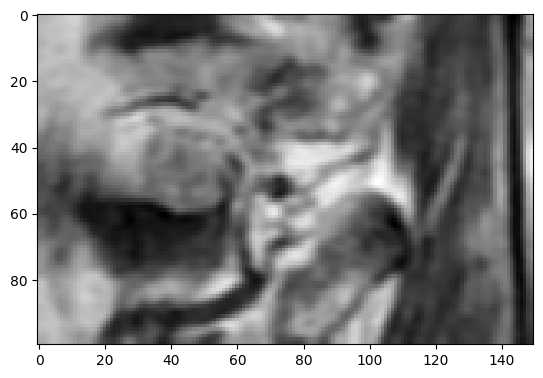

In [165]:
plt.imshow(x_[0][0][0], cmap="gray")

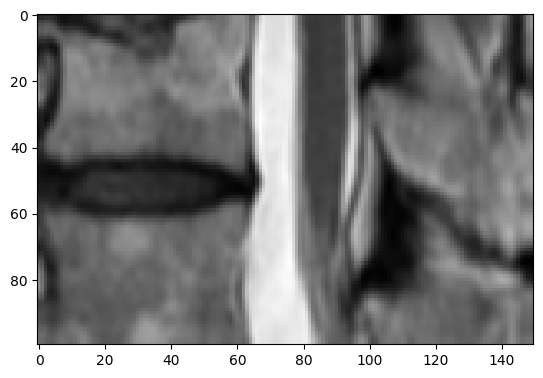

In [166]:
plt.imshow(x_[1][0][0], cmap="gray")

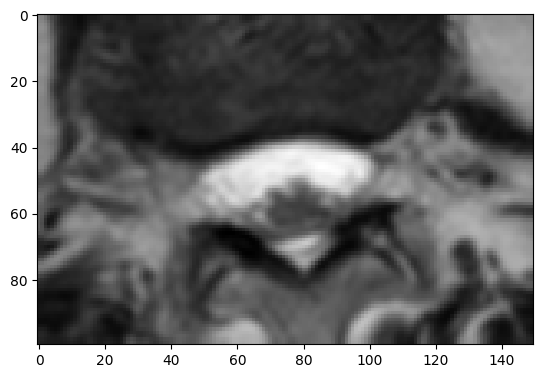

In [192]:
plt.imshow(x_[2][0][0], cmap="gray")

In [167]:
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

# Dataset gốc
dataset = SpineMultiViewDiscDataset(sagittal_t1_crop, sagittal_t2_crop, df_axis_cropped, transform=train_transform)

# Tỉ lệ train/val, ví dụ 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# ---- Train loader với WeightedRandomSampler ----
labels_train = [train_dataset[i][1].item() for i in range(len(train_dataset))]
sample_weights = [1.0 if l == 0 else 2.0 if l == 1 else 4.0 for l in labels_train]
sample_weights = torch.tensor(sample_weights, dtype=torch.float)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

# ---- Val loader (ko sampler, chỉ shuffle=False) ----
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Base Model

## 1. Encoder (resnet18 without FC layer)

In [168]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import OneCycleLR

In [169]:
class MultiModalEncoderSingleSlice(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base = models.resnet18(pretrained=pretrained)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.d_model = in_features

    def forward(self, x):
        """
        x: [B, 3, 1, 1, H, W]
        """
        B, V, N, C, H, W = x.shape
        assert N == 1, "Hiện tại chỉ support 1 lát mỗi view"

        x = x.view(B*V, C, H, W)   # [B*3,1,H,W]
        x = x.repeat(1, 3, 1, 1)   # [B*3,3,H,W]

        feat = self.backbone(x)    # [B*3,512]
        feat = feat.view(B, V, -1) # [B,3,512]

        return feat


In [170]:
import torch

x = torch.rand(2, 2, 1, 1, 150, 100)
encoder = MultiModalEncoderSingleSlice(pretrained=True)  # pretrained=True nếu có internet
feat = encoder(x)
print(feat.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 2, 512])


## 2. Transformer Encoder

In [171]:
import torch.nn as nn

class ViewTransformer(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_layers=2, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True   # để input là [B, seq, d]
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        """
        x: [B, 3, 512]   # 3 views = sequence length 3
        return: [B, 3, 512]
        """
        out = self.transformer(x)
        return out

In [172]:
view_transformer = ViewTransformer()
out = view_transformer(feat)
print(out.shape)

torch.Size([2, 2, 512])


# Center - Spinal Canal Stenosis condition

## 1. Model

In [173]:
class MultiModalPipeline_center(nn.Module):
    def __init__(self, pretrained=True, num_classes=3):
        super().__init__()
        self.encoder = MultiModalEncoderSingleSlice(pretrained=pretrained)  # [B,3,512]
        self.transformer = ViewTransformer(d_model=512, nhead=8, num_layers=2)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        feat = self.encoder(x)              # [B,3,512]
        feat_trans = self.transformer(feat) # [B,3,512]
        # pool across views (mean pooling)
        pooled = feat_trans.mean(dim=1)     # [B,512]
        out = self.fc(pooled)               # [B,num_classes]
        return out, feat_trans


In [174]:
x = torch.randn(2, 3, 1, 1, 100, 150)  # batch=2
model = MultiModalPipeline_center(pretrained=True, num_classes=3)

logits, feat_trans = model(x)
print("Logits:", logits.shape)       # [2,2]
print("Transformer output:", feat_trans.shape)  # [2,3,512]

Logits: torch.Size([2, 3])
Transformer output: torch.Size([2, 3, 512])


## 3. Train model

In [175]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalPipeline_center(pretrained=True, num_classes=3).to(device)

# định nghĩa weight cho từng class
class_weights = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
# ===== Optimizer =====
optimizer = optim.AdamW(model.parameters(), lr=2.5e-4)

# ===== Scheduler: OneCycleLR =====
epochs = 30
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * epochs
warmup_steps = int(total_steps * 0.3)   # 3/10 = 30% warmup

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2.5e-5,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

Epoch 1/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Epoch 1, Train Loss: 1.2083


Epoch 1/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


Epoch 1, Validation Accuracy: 0.2913
Saved best model with val acc: 0.2913


Epoch 2/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


Epoch 2, Train Loss: 1.0145


Epoch 2/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Epoch 2, Validation Accuracy: 0.7729
Saved best model with val acc: 0.7729


Epoch 3/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


Epoch 3, Train Loss: 0.8493


Epoch 3/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Epoch 3, Validation Accuracy: 0.8417
Saved best model with val acc: 0.8417


Epoch 4/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


Epoch 4, Train Loss: 0.7207


Epoch 4/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]


Epoch 4, Validation Accuracy: 0.8394


Epoch 5/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


Epoch 5, Train Loss: 0.5628


Epoch 5/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Epoch 5, Validation Accuracy: 0.8532
Saved best model with val acc: 0.8532


Epoch 6/30 [Train]: 100%|██████████| 28/28 [00:52<00:00,  1.87s/it]


Epoch 6, Train Loss: 0.4606


Epoch 6/30 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch 6, Validation Accuracy: 0.8899
Saved best model with val acc: 0.8899


Epoch 7/30 [Train]: 100%|██████████| 28/28 [01:05<00:00,  2.35s/it]


Epoch 7, Train Loss: 0.3658


Epoch 7/30 [Val]: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


Epoch 7, Validation Accuracy: 0.8899


Epoch 8/30 [Train]: 100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


Epoch 8, Train Loss: 0.2867


Epoch 8/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


Epoch 8, Validation Accuracy: 0.8807


Epoch 9/30 [Train]: 100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


Epoch 9, Train Loss: 0.2242


Epoch 9/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Epoch 9, Validation Accuracy: 0.8922
Saved best model with val acc: 0.8922


Epoch 10/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Epoch 10, Train Loss: 0.1862


Epoch 10/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


Epoch 10, Validation Accuracy: 0.8876


Epoch 11/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Epoch 11, Train Loss: 0.1565


Epoch 11/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Epoch 11, Validation Accuracy: 0.8899


Epoch 12/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


Epoch 12, Train Loss: 0.1419


Epoch 12/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Epoch 12, Validation Accuracy: 0.8899


Epoch 13/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


Epoch 13, Train Loss: 0.1094


Epoch 13/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


Epoch 13, Validation Accuracy: 0.8968
Saved best model with val acc: 0.8968


Epoch 14/30 [Train]: 100%|██████████| 28/28 [00:43<00:00,  1.57s/it]


Epoch 14, Train Loss: 0.1078


Epoch 14/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Epoch 14, Validation Accuracy: 0.8899


Epoch 15/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


Epoch 15, Train Loss: 0.0881


Epoch 15/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Epoch 15, Validation Accuracy: 0.9060
Saved best model with val acc: 0.9060


Epoch 16/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


Epoch 16, Train Loss: 0.0736


Epoch 16/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Epoch 16, Validation Accuracy: 0.8899


Epoch 17/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


Epoch 17, Train Loss: 0.0688


Epoch 17/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Epoch 17, Validation Accuracy: 0.8899


Epoch 18/30 [Train]: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it]


Epoch 18, Train Loss: 0.0610


Epoch 18/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Epoch 18, Validation Accuracy: 0.8968


Epoch 19/30 [Train]: 100%|██████████| 28/28 [00:48<00:00,  1.75s/it]


Epoch 19, Train Loss: 0.0735


Epoch 19/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Epoch 19, Validation Accuracy: 0.9083
Saved best model with val acc: 0.9083


Epoch 20/30 [Train]: 100%|██████████| 28/28 [00:51<00:00,  1.84s/it]


Epoch 20, Train Loss: 0.0537


Epoch 20/30 [Val]: 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Epoch 20, Validation Accuracy: 0.9060


Epoch 21/30 [Train]: 100%|██████████| 28/28 [00:53<00:00,  1.91s/it]


Epoch 21, Train Loss: 0.0539


Epoch 21/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Epoch 21, Validation Accuracy: 0.9174
Saved best model with val acc: 0.9174


Epoch 22/30 [Train]: 100%|██████████| 28/28 [00:47<00:00,  1.68s/it]


Epoch 22, Train Loss: 0.0550


Epoch 22/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


Epoch 22, Validation Accuracy: 0.9151


Epoch 23/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


Epoch 23, Train Loss: 0.0606


Epoch 23/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Epoch 23, Validation Accuracy: 0.9151


Epoch 24/30 [Train]: 100%|██████████| 28/28 [00:49<00:00,  1.76s/it]


Epoch 24, Train Loss: 0.0473


Epoch 24/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Epoch 24, Validation Accuracy: 0.8991


Epoch 25/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


Epoch 25, Train Loss: 0.0410


Epoch 25/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


Epoch 25, Validation Accuracy: 0.9037


Epoch 26/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


Epoch 26, Train Loss: 0.0311


Epoch 26/30 [Val]: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Epoch 26, Validation Accuracy: 0.8945


Epoch 27/30 [Train]: 100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


Epoch 27, Train Loss: 0.0422


Epoch 27/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Epoch 27, Validation Accuracy: 0.9083


Epoch 28/30 [Train]: 100%|██████████| 28/28 [00:49<00:00,  1.76s/it]


Epoch 28, Train Loss: 0.0389


Epoch 28/30 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch 28, Validation Accuracy: 0.8968


Epoch 29/30 [Train]: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


Epoch 29, Train Loss: 0.0326


Epoch 29/30 [Val]: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Epoch 29, Validation Accuracy: 0.9128


Epoch 30/30 [Train]: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


Epoch 30, Train Loss: 0.0455


Epoch 30/30 [Val]: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Epoch 30, Validation Accuracy: 0.8899
Best validation accuracy: 0.9174


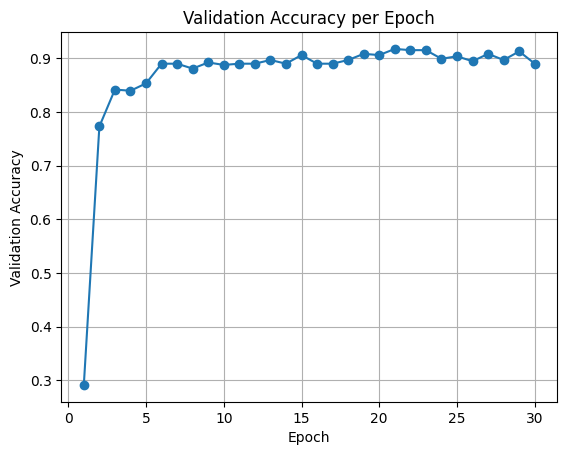

In [176]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

num_epochs = 30
best_acc = 0.0
best_model_state = None  # lưu state_dict tốt nhất
save_path = "best_model.pth"

# ---- List để lưu val acc từng epoch ----
val_acc_history = []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # ---- Validation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)[0]
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    val_acc_history.append(acc)  # lưu acc cho epoch này
    print(f"Epoch {epoch+1}, Validation Accuracy: {acc:.4f}")

    # ---- Lưu model tốt nhất ----
    if acc > best_acc:
        best_acc = acc
        best_model_state = model.state_dict()
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": best_model_state,
            "optimizer_state_dict": optimizer.state_dict(),
            "best_acc": best_acc,
        }, save_path)
        print(f"Saved best model with val acc: {best_acc:.4f}")

# --- Load lại model tốt nhất để eval ---
model.load_state_dict(best_model_state)
model.eval()
print(f"Best validation accuracy: {best_acc:.4f}")

# --- Plot val accuracy qua các epoch ---
plt.figure()
plt.plot(range(1, num_epochs+1), val_acc_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.show()


### Evaluate

Validation: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


Validation Accuracy: 0.9174
Accuracy: 0.9174
Classification Report:
               precision    recall  f1-score   support

           0     0.9685    0.9762    0.9723       378
           1     0.5294    0.4865    0.5070        37
           2     0.6190    0.6190    0.6190        21

    accuracy                         0.9174       436
   macro avg     0.7057    0.6939    0.6995       436
weighted avg     0.9144    0.9174    0.9158       436



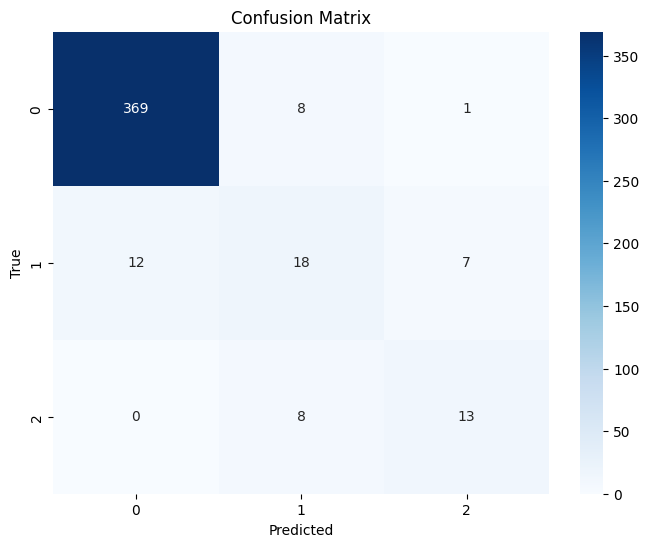

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# ---- Validation + lưu nhãn để vẽ confusion matrix ----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Validation"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)[0]
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
correct = sum([p == t for p, t in zip(all_preds, all_labels)])
total = len(all_labels)
acc = correct / total
print(f"Validation Accuracy: {acc:.4f}")

# Metric precision, recall, f1-score
# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1-score cho từng class
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Side - Multilabel

## 1. Class dataset

In [178]:
class SpineMultiViewDiscDataset(Dataset):
    def __init__(self, df1, df2, df3, resize=(150, 100), base_dir=TRAIN_DIR, base_dir_axial=BASE_DIR, transform=None, iloc=0, conditions=['scs']):
        self.samples = []
        self.resize = resize
        self.base_dir = base_dir
        self.base_dir_axial = base_dir_axial
        self.transform = transform
        self.iloc = iloc
        self.conditions = conditions if isinstance(conditions, list) else [conditions]

        label_map = {'N': 0, 'M': 1, 'S': 2}

        # Lấy danh sách study_id
        study_ids = df1['study_id'].unique()

        for sid in study_ids:
            rows1 = df1[df1['study_id'] == sid]
            rows2 = df2[df2['study_id'] == sid]
            rows3 = df3[df3['study_id'] == sid]
            if len(rows1) == 0 or len(rows2) == 0 or len(rows3) != 5:
                continue

            row1 = rows1.iloc[self.iloc]
            row2 = rows2.iloc[0]

            coords1 = row1['coords']
            coords2 = row2['coords']

            # mỗi condition sẽ có 1 list label riêng
            labels_dict = {cond: row1[cond] for cond in self.conditions}

            for i in range(5):  # 5 disc levels
                row3 = rows3[rows3["pred_level"] == i + 1].iloc[0]

                # tạo vector nhãn cho tất cả conditions
                labels_vec = []
                for cond in self.conditions:
                    cond_labels = labels_dict[cond]
                    label_char = cond_labels[0][i] if isinstance(cond_labels, list) else cond_labels[i]
                    label = label_map.get(label_char)
                    labels_vec.append(label)

                sample = {
                    'file1': f"{self.base_dir}/{row1['file_path']}",
                    'file2': f"{self.base_dir}/{row2['file_path']}",
                    'file3': f"{self.base_dir_axial}/{row3['study_id']}___{row3['series_id']}___{row3['instance_number']}.png",
                    'all_coords1': coords1,
                    'all_coords2': coords2,
                    'labels': labels_vec,
                    'disc_level': i
                }
                self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        img1 = load_dcm_image(sample['file1'])
        img2 = load_dcm_image(sample['file2'])
        img3 = load_png_image(sample['file3'])

        crop1 = crop_patch_by_spline(img1, sample['all_coords1'], sample['disc_level'],
                                     box_width=self.resize[0], box_height=self.resize[1])
        crop2 = crop_patch_by_spline(img2, sample['all_coords2'], sample['disc_level'],
                                     box_width=self.resize[0], box_height=self.resize[1])
        
        stacked = np.stack([crop1, crop2, img3], axis=-1)  # [H, W, 3]

        if self.transform:
            augmented = self.transform(image=stacked)
            stacked = augmented["image"]

        stacked = np.transpose(stacked, (2, 0, 1))
        stacked = stacked.reshape(3, 1, 1, 100, 150)

        labels = torch.tensor(sample['labels'], dtype=torch.long)  # vector nhãn

        return torch.tensor(stacked, dtype=torch.float32), labels

In [179]:
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

dataset_L = SpineMultiViewDiscDataset(sagittal_t1_crop, sagittal_t2_crop, df_axis_cropped, transform=train_transform, iloc=0, conditions=["l_nfn", "l_ss"])
# Tỉ lệ train/val, ví dụ 80/20 
train_size = int(0.8 * len(dataset_L)) 
val_size = len(dataset_L) - train_size 
train_dataset_L, val_dataset_L = random_split(dataset_L, [train_size, val_size])

# ---- Train loader ----
train_loader_L = DataLoader(
    train_dataset_L,
    batch_size=64,
    shuffle=True,       # bỏ sampler, dùng shuffle
    num_workers=4,
    pin_memory=True
)

# ---- Validation loader ----
val_loader_L = DataLoader(
    val_dataset_L,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


## 2. Side Model

In [ ]:
class MultiModalPipeline(nn.Module):
    def __init__(self, pretrained=True, num_classes=[3]):
        """
        num_classes: list[int], mỗi phần tử là số class cho một condition
                     ví dụ [3, 3] nghĩa là 2 conditions, mỗi cái có 3 class
        """
        super().__init__()
        self.encoder = MultiModalEncoderSingleSlice(pretrained=pretrained)  # [B,3,512]
        self.transformer = ViewTransformer(d_model=512, nhead=8, num_layers=2)

        # tạo các head cho từng condition
        self.heads = nn.ModuleList([nn.Linear(512, n_cls) for n_cls in num_classes])

    def forward(self, x):
        feat = self.encoder(x)              # [B,3,512]
        feat_trans = self.transformer(feat) # [B,3,512]

        # pool across views (mean pooling)
        pooled = feat_trans.mean(dim=1)     # [B,512]

        # mỗi condition 1 head riêng
        outputs = [head(pooled) for head in self.heads]  # list of [B, num_classes]

        return outputs, feat_trans

## 2. Train and Val function

In [180]:
import torch
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=1, save_path="best_model.pth"):
    """
    Train a multi-task model, save the best model, return it and store val acc history per condition.
    """
    best_acc = 0.0
    best_model_state = None
    val_acc_history = []  # lưu acc từng condition mỗi epoch

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(imgs)

            # Multi-task loss
            loss = 0
            for i, logits in enumerate(outputs):
                loss += criterion(logits, labels[:, i])
            loss = loss / len(outputs)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

        # ---- Validation ----
        model.eval()
        correct = [0] * len(outputs)
        total = 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs, _ = model(imgs)

                for i, logits in enumerate(outputs):
                    preds = logits.argmax(dim=1)
                    correct[i] += (preds == labels[:, i]).sum().item()

                total += labels.size(0)

        accs = [c / total for c in correct]
        val_acc_history.append(accs)  # lưu acc từng condition
        avg_acc = sum(accs) / len(accs)
        acc_str = " | ".join([f"Cond{i+1}: {a:.4f}" for i, a in enumerate(accs)])
        print(f"Epoch {epoch+1}, Validation Accuracies: {acc_str}")

        # ---- Lưu model tốt nhất ----
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_state = model.state_dict()
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": best_model_state,
                "optimizer_state_dict": optimizer.state_dict(),
                "best_acc": best_acc,
                "best_accs_per_condition": accs,  # lưu luôn acc từng condition tốt nhất
            }, save_path)
            print(f"Saved best model with avg acc: {best_acc:.4f}")

    # --- Trả về model tốt nhất và lịch sử val acc ---
    model.load_state_dict(best_model_state)
    model.eval()
    return model, val_acc_history

In [181]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import torch

def validate_and_plot_cm(model, val_loader, device):
    """
    Validate a multi-condition model, print accuracy, precision, recall, F1, 
    and plot confusion matrices for each condition.

    Args:
        model: PyTorch model, should return (outputs, aux) where outputs is a list of logits per condition.
        val_loader: DataLoader for validation data.
        device: torch.device.
    """
    model.eval()
    correct = None
    total = 0

    # Lưu nhãn để vẽ confusion matrix và tính metrics
    all_preds, all_labels = None, None

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, _ = model(imgs)

            if correct is None:
                correct = [0] * len(outputs)
                all_preds = [[] for _ in range(len(outputs))]
                all_labels = [[] for _ in range(len(outputs))]

            for i, logits in enumerate(outputs):
                preds = logits.argmax(dim=1)
                correct[i] += (preds == labels[:, i]).sum().item()
                all_preds[i].extend(preds.cpu().numpy())
                all_labels[i].extend(labels[:, i].cpu().numpy())

            total += labels.size(0)

    # Accuracy
    accs = [c / total for c in correct]
    for i, a in enumerate(accs):
        print(f"Condition {i+1} Accuracy: {a:.4f}")

    # Vẽ confusion matrix và tính metrics cho từng condition
    for i in range(len(outputs)):
        cm = confusion_matrix(all_labels[i], all_preds[i])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - Condition {i+1}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Classification report: precision, recall, f1-score
        print(f"Condition {i+1} Metrics:")
        report = classification_report(all_labels[i], all_preds[i], digits=4)
        print(report)

import matplotlib.pyplot as plt

def plot_val_acc(val_acc_history):
    """
    Plot validation accuracy per condition over epochs.

    Args:
        val_acc_history: list of list, mỗi phần tử là acc từng condition của 1 epoch
    """
    num_conditions = len(val_acc_history[0])
    epochs = range(1, len(val_acc_history) + 1)

    plt.figure(figsize=(8, 6))
    for i in range(num_conditions):
        cond_acc = [epoch_acc[i] for epoch_acc in val_acc_history]
        plt.plot(epochs, cond_acc, marker='o', label=f'Condition {i+1}')

    plt.title("Validation Accuracy per Condition")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.show()


## 3. Left Neural Foraminal Narrowing, Left Subarticular Stenosis

In [183]:
# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_L = MultiModalPipeline(pretrained=True, num_classes=[3, 3]).to(device)

# ===== Loss (có trọng số cho class imbalance) =====
class_weights = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ===== Optimizer =====
optimizer = optim.AdamW(model_L.parameters(), lr=2.5e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [184]:
model_L, val_acc_history_L = train(model_L, train_loader_L, val_loader_L, criterion, optimizer, device, num_epochs=30)

Epoch 1/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 1, Train Loss: 0.8286


Epoch 1/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 1, Validation Accuracies: Cond1: 0.7913 | Cond2: 0.7156
Saved best model with avg acc: 0.7534


Epoch 2/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 2, Train Loss: 0.6381


Epoch 2/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 2, Validation Accuracies: Cond1: 0.7477 | Cond2: 0.7500


Epoch 3/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 3, Train Loss: 0.5779


Epoch 3/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 3, Validation Accuracies: Cond1: 0.7546 | Cond2: 0.7041


Epoch 4/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 4, Train Loss: 0.4758


Epoch 4/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 4, Validation Accuracies: Cond1: 0.7959 | Cond2: 0.7385
Saved best model with avg acc: 0.7672


Epoch 5/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 5, Train Loss: 0.4098


Epoch 5/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 5, Validation Accuracies: Cond1: 0.8096 | Cond2: 0.7317
Saved best model with avg acc: 0.7706


Epoch 6/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 6, Train Loss: 0.3716


Epoch 6/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch 6, Validation Accuracies: Cond1: 0.7936 | Cond2: 0.7454


Epoch 7/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Epoch 7, Train Loss: 0.3694


Epoch 7/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch 7, Validation Accuracies: Cond1: 0.7913 | Cond2: 0.7500


Epoch 8/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 8, Train Loss: 0.3266


Epoch 8/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 8, Validation Accuracies: Cond1: 0.7821 | Cond2: 0.6468


Epoch 9/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 9, Train Loss: 0.2991


Epoch 9/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch 9, Validation Accuracies: Cond1: 0.7752 | Cond2: 0.7661


Epoch 10/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 10, Train Loss: 0.2792


Epoch 10/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch 10, Validation Accuracies: Cond1: 0.7936 | Cond2: 0.7271


Epoch 11/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 11, Train Loss: 0.2311


Epoch 11/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch 11, Validation Accuracies: Cond1: 0.7706 | Cond2: 0.7500


Epoch 12/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 12, Train Loss: 0.2046


Epoch 12/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch 12, Validation Accuracies: Cond1: 0.7752 | Cond2: 0.7225


Epoch 13/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 13, Train Loss: 0.2006


Epoch 13/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 13, Validation Accuracies: Cond1: 0.7890 | Cond2: 0.7500


Epoch 14/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 14, Train Loss: 0.1601


Epoch 14/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 14, Validation Accuracies: Cond1: 0.8005 | Cond2: 0.7615
Saved best model with avg acc: 0.7810


Epoch 15/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 15, Train Loss: 0.1512


Epoch 15/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch 15, Validation Accuracies: Cond1: 0.7890 | Cond2: 0.7569


Epoch 16/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 16, Train Loss: 0.1787


Epoch 16/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 16, Validation Accuracies: Cond1: 0.8050 | Cond2: 0.7202


Epoch 17/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 17, Train Loss: 0.1493


Epoch 17/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 17, Validation Accuracies: Cond1: 0.7523 | Cond2: 0.7569


Epoch 18/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 18, Train Loss: 0.1590


Epoch 18/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch 18, Validation Accuracies: Cond1: 0.7821 | Cond2: 0.7706


Epoch 19/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Epoch 19, Train Loss: 0.1528


Epoch 19/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 19, Validation Accuracies: Cond1: 0.8028 | Cond2: 0.7729
Saved best model with avg acc: 0.7878


Epoch 20/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Epoch 20, Train Loss: 0.1199


Epoch 20/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch 20, Validation Accuracies: Cond1: 0.8050 | Cond2: 0.7729
Saved best model with avg acc: 0.7890


Epoch 21/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 21, Train Loss: 0.1063


Epoch 21/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch 21, Validation Accuracies: Cond1: 0.7706 | Cond2: 0.7477


Epoch 22/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 22, Train Loss: 0.1242


Epoch 22/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch 22, Validation Accuracies: Cond1: 0.7569 | Cond2: 0.7408


Epoch 23/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Epoch 23, Train Loss: 0.1236


Epoch 23/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 23, Validation Accuracies: Cond1: 0.7798 | Cond2: 0.7408


Epoch 24/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Epoch 24, Train Loss: 0.0829


Epoch 24/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 24, Validation Accuracies: Cond1: 0.7982 | Cond2: 0.7385


Epoch 25/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 25, Train Loss: 0.1008


Epoch 25/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 25, Validation Accuracies: Cond1: 0.8188 | Cond2: 0.7661
Saved best model with avg acc: 0.7924


Epoch 26/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 26, Train Loss: 0.0928


Epoch 26/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 26, Validation Accuracies: Cond1: 0.7959 | Cond2: 0.7523


Epoch 27/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Epoch 27, Train Loss: 0.0802


Epoch 27/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch 27, Validation Accuracies: Cond1: 0.7752 | Cond2: 0.7156


Epoch 28/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 28, Train Loss: 0.0704


Epoch 28/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch 28, Validation Accuracies: Cond1: 0.8028 | Cond2: 0.7729


Epoch 29/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 29, Train Loss: 0.0608


Epoch 29/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 29, Validation Accuracies: Cond1: 0.8165 | Cond2: 0.7385


Epoch 30/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 30, Train Loss: 0.0671


Epoch 30/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

Epoch 30, Validation Accuracies: Cond1: 0.7683 | Cond2: 0.7271


### Evaluate

Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Condition 1 Accuracy: 0.7752
Condition 2 Accuracy: 0.6950


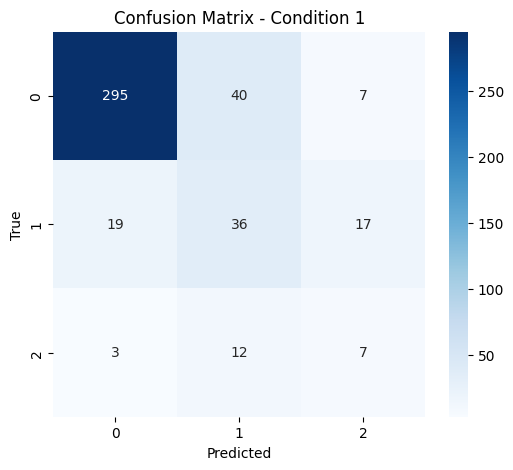

Condition 1 Metrics:
              precision    recall  f1-score   support

           0     0.9306    0.8626    0.8953       342
           1     0.4091    0.5000    0.4500        72
           2     0.2258    0.3182    0.2642        22

    accuracy                         0.7752       436
   macro avg     0.5218    0.5603    0.5365       436
weighted avg     0.8089    0.7752    0.7899       436



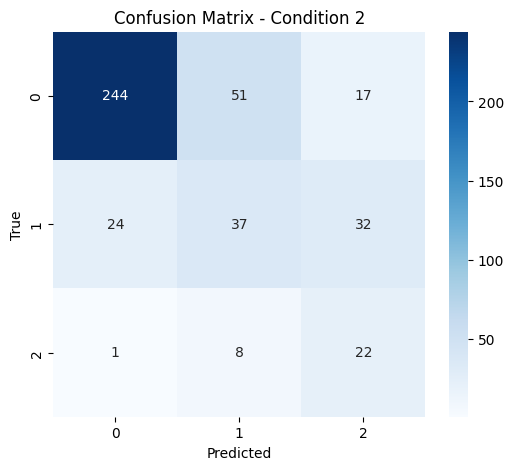

Condition 2 Metrics:
              precision    recall  f1-score   support

           0     0.9071    0.7821    0.8399       312
           1     0.3854    0.3978    0.3915        93
           2     0.3099    0.7097    0.4314        31

    accuracy                         0.6950       436
   macro avg     0.5341    0.6299    0.5543       436
weighted avg     0.7533    0.6950    0.7152       436



In [185]:
validate_and_plot_cm(model_L, val_loader_L, device)

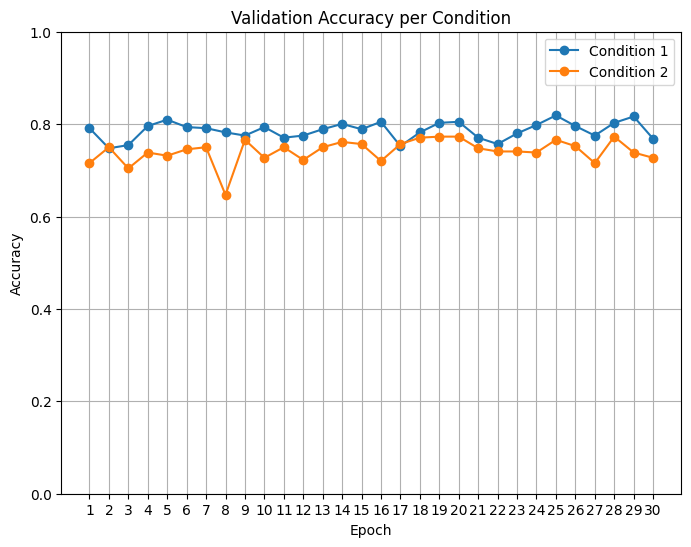

In [186]:
plot_val_acc(val_acc_history_L)

## 4. Right Neural Foraminal Narrowing, Right Subarticular Stenosis

In [187]:
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

dataset_R = SpineMultiViewDiscDataset(sagittal_t1_crop, sagittal_t2_crop, df_axis_cropped, transform=train_transform, iloc=1, conditions=["r_nfn", "r_ss"])
# Tỉ lệ train/val, ví dụ 80/20 
train_size = int(0.8 * len(dataset_R)) 
val_size = len(dataset) - train_size 
train_dataset_R, val_dataset_R = random_split(dataset_R, [train_size, val_size])

# ---- Train loader ----
train_loader_R = DataLoader(
    train_dataset_R,
    batch_size=64,
    shuffle=True,       # bỏ sampler, dùng shuffle
    num_workers=4,
    pin_memory=True
)

# ---- Validation loader ----
val_loader_R = DataLoader(
    val_dataset_R,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [188]:
# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_R = MultiModalPipeline(pretrained=True, num_classes=[3, 3]).to(device)

# ===== Loss (có trọng số cho class imbalance) =====
class_weights = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ===== Optimizer =====
optimizer = optim.AdamW(model_R.parameters(), lr=2.5e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [189]:
model_R, val_acc_history_R = train(model_R, train_loader_R, val_loader_R, criterion, optimizer, device, num_epochs=30)

Epoch 1/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


Epoch 1, Train Loss: 0.9002


Epoch 1/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Epoch 1, Validation Accuracies: Cond1: 0.7683 | Cond2: 0.7385
Saved best model with avg acc: 0.7534


Epoch 2/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 2, Train Loss: 0.6568


Epoch 2/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch 2, Validation Accuracies: Cond1: 0.7179 | Cond2: 0.6216


Epoch 3/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Epoch 3, Train Loss: 0.5649


Epoch 3/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 3, Validation Accuracies: Cond1: 0.7615 | Cond2: 0.6422


Epoch 4/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Epoch 4, Train Loss: 0.5108


Epoch 4/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 4, Validation Accuracies: Cond1: 0.7752 | Cond2: 0.6606


Epoch 5/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 5, Train Loss: 0.4253


Epoch 5/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch 5, Validation Accuracies: Cond1: 0.7683 | Cond2: 0.7500
Saved best model with avg acc: 0.7592


Epoch 6/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Epoch 6, Train Loss: 0.4195


Epoch 6/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch 6, Validation Accuracies: Cond1: 0.8050 | Cond2: 0.7110


Epoch 7/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 7, Train Loss: 0.3626


Epoch 7/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch 7, Validation Accuracies: Cond1: 0.7317 | Cond2: 0.6353


Epoch 8/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 8, Train Loss: 0.3195


Epoch 8/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 8, Validation Accuracies: Cond1: 0.8142 | Cond2: 0.7385
Saved best model with avg acc: 0.7764


Epoch 9/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


Epoch 9, Train Loss: 0.2973


Epoch 9/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 9, Validation Accuracies: Cond1: 0.7867 | Cond2: 0.7661


Epoch 10/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Epoch 10, Train Loss: 0.2564


Epoch 10/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 10, Validation Accuracies: Cond1: 0.8050 | Cond2: 0.7523
Saved best model with avg acc: 0.7787


Epoch 11/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


Epoch 11, Train Loss: 0.2278


Epoch 11/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 11, Validation Accuracies: Cond1: 0.7339 | Cond2: 0.6720


Epoch 12/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


Epoch 12, Train Loss: 0.1822


Epoch 12/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch 12, Validation Accuracies: Cond1: 0.6881 | Cond2: 0.7546


Epoch 13/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Epoch 13, Train Loss: 0.1752


Epoch 13/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 13, Validation Accuracies: Cond1: 0.8096 | Cond2: 0.7821
Saved best model with avg acc: 0.7959


Epoch 14/30 [Train]: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Epoch 14, Train Loss: 0.2230


Epoch 14/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 14, Validation Accuracies: Cond1: 0.7018 | Cond2: 0.7683


Epoch 15/30 [Train]: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


Epoch 15, Train Loss: 0.2075


Epoch 15/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 15, Validation Accuracies: Cond1: 0.7982 | Cond2: 0.7546


Epoch 16/30 [Train]: 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


Epoch 16, Train Loss: 0.1506


Epoch 16/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch 16, Validation Accuracies: Cond1: 0.7110 | Cond2: 0.7454


Epoch 17/30 [Train]: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Epoch 17, Train Loss: 0.1377


Epoch 17/30 [Val]: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch 17, Validation Accuracies: Cond1: 0.7569 | Cond2: 0.7431


Epoch 18/30 [Train]: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Epoch 18, Train Loss: 0.1624


Epoch 18/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 18, Validation Accuracies: Cond1: 0.8028 | Cond2: 0.7156


Epoch 19/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Epoch 19, Train Loss: 0.1499


Epoch 19/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Epoch 19, Validation Accuracies: Cond1: 0.8073 | Cond2: 0.7592


Epoch 20/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Epoch 20, Train Loss: 0.0980


Epoch 20/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 20, Validation Accuracies: Cond1: 0.8303 | Cond2: 0.7477


Epoch 21/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Epoch 21, Train Loss: 0.0928


Epoch 21/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 21, Validation Accuracies: Cond1: 0.7706 | Cond2: 0.8005


Epoch 22/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Epoch 22, Train Loss: 0.1213


Epoch 22/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


Epoch 22, Validation Accuracies: Cond1: 0.8165 | Cond2: 0.7638


Epoch 23/30 [Train]: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]


Epoch 23, Train Loss: 0.0950


Epoch 23/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 23, Validation Accuracies: Cond1: 0.8119 | Cond2: 0.6904


Epoch 24/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]


Epoch 24, Train Loss: 0.0920


Epoch 24/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 24, Validation Accuracies: Cond1: 0.7179 | Cond2: 0.7592


Epoch 25/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]


Epoch 25, Train Loss: 0.1203


Epoch 25/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch 25, Validation Accuracies: Cond1: 0.7890 | Cond2: 0.6055


Epoch 26/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Epoch 26, Train Loss: 0.1213


Epoch 26/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 26, Validation Accuracies: Cond1: 0.8050 | Cond2: 0.7156


Epoch 27/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


Epoch 27, Train Loss: 0.0732


Epoch 27/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch 27, Validation Accuracies: Cond1: 0.8211 | Cond2: 0.7248


Epoch 28/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Epoch 28, Train Loss: 0.0620


Epoch 28/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch 28, Validation Accuracies: Cond1: 0.8303 | Cond2: 0.6743


Epoch 29/30 [Train]: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


Epoch 29, Train Loss: 0.0723


Epoch 29/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 29, Validation Accuracies: Cond1: 0.8073 | Cond2: 0.7408


Epoch 30/30 [Train]: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


Epoch 30, Train Loss: 0.0746


Epoch 30/30 [Val]: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]

Epoch 30, Validation Accuracies: Cond1: 0.7959 | Cond2: 0.7454


### Evaluate

Validation: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Condition 1 Accuracy: 0.8073
Condition 2 Accuracy: 0.7041


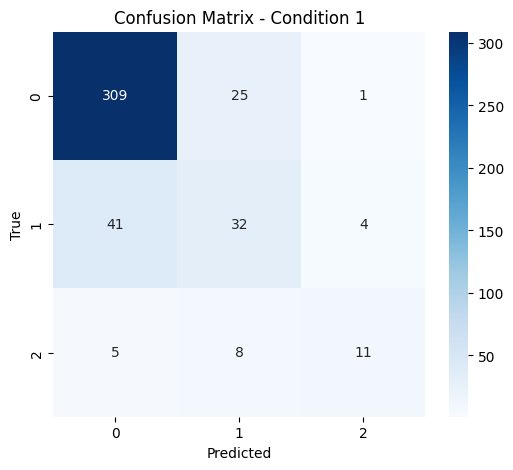

Condition 1 Metrics:
              precision    recall  f1-score   support

           0     0.8704    0.9224    0.8957       335
           1     0.4923    0.4156    0.4507        77
           2     0.6875    0.4583    0.5500        24

    accuracy                         0.8073       436
   macro avg     0.6834    0.5988    0.6321       436
weighted avg     0.7936    0.8073    0.7980       436



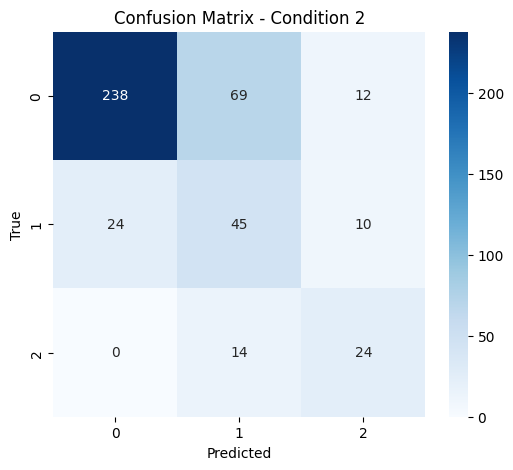

Condition 2 Metrics:
              precision    recall  f1-score   support

           0     0.9084    0.7461    0.8193       319
           1     0.3516    0.5696    0.4348        79
           2     0.5217    0.6316    0.5714        38

    accuracy                         0.7041       436
   macro avg     0.5939    0.6491    0.6085       436
weighted avg     0.7738    0.7041    0.7280       436



In [190]:
validate_and_plot_cm(model_R, val_loader_R, device)

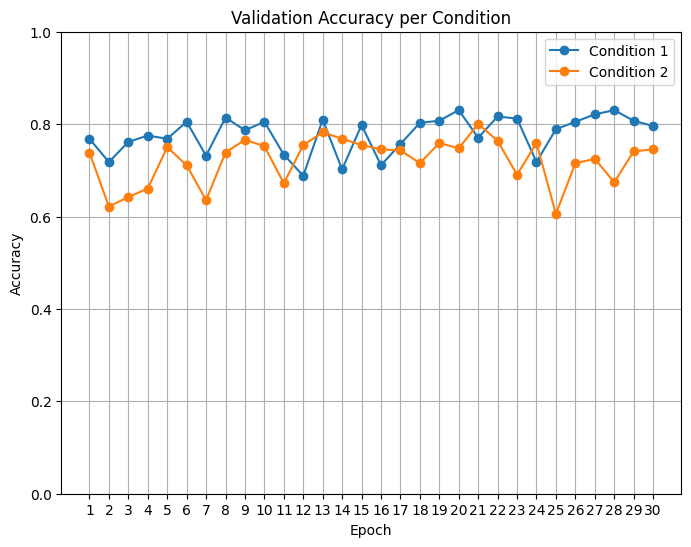

In [191]:
plot_val_acc(val_acc_history_R)